<a href="https://colab.research.google.com/github/Alexandre77777/neural_networks/blob/main/7.%20%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%B0%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20%D1%81%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9%20%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8/%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%967_%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%B0_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87_%D1%81%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №7. Использование автоэнкодера для решения задач семантической сегментации**

### Для выполнения задания необходимо скачать датасет по ссылке (снимки и маски, Version 1) . Обучить нейронную сеть предсказывать полноразмерную маску по загруженному снимку (см. теорию)

- ### Ссылка на датасет: https://landcover.ai.linuxpolska.com/#dataset



# Задание №1. Обучение готовой модели семантической сегментации для классификации спутниковых снимков

- Для работы с tiff-изображениями предлагается использовать библиотеку tifffile

In [ ]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


*Далее даны примеры кода, для их корректной работы пути необходимо сменить на Ваши*

### 1.1. Проверка вывода растра и масок

In [ ]:
temp_img = tiff.imread('C:\\Users\\sa32\\YandexDisk\\VIZARD\\Composit\\S1A_EW_GRDM_1SDH_20210928T011042_20210928T011146_039875_04B7B8_C842.tif')
# plt.imshow(temp_img[:,:,0])

temp_mask = tiff.imread('C:/Users/sa32/YandexDisk/VIZARD/Classification/S1A_EW_GRDM_1SDH_20210928T011042_20210928T011146_039875_04B7B8_C842.tif')
plt.imshow(temp_mask)

print(temp_img.shape)
print(temp_img.dtype)
print(temp_mask.shape)

labels, count = np.unique(temp_mask[:,:,2], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

In [ ]:
root_directory = r"C:/Users/sa32/YandexDisk/VIZARD/"

patch_size = 256

### 1.2. Обрезка исходных растров на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [ ]:
#Считываем изображения из подкаталога 'images'.
#Поскольку все изображения имеют разный размер, у нас есть 2 варианта: изменить размер или обрезать.
#Но некоторые изображения слишком большие, а некоторые маленькие. Изменение размера изменит размер реальных объектов.
#Поэтому мы обрезаем их до ближайшего размера, кратного 256, а затем
#разделим все изображения на участки размером 256x256x3.
img_dir=root_directory+"Composit/"
for path, subdirs, files in os.walk(img_dir):
    print(path)
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    images = os.listdir(path)
    print(images)
    for i, image_name in enumerate(images):
        if image_name.endswith(".tif"):

            image = tiff.imread(path+"/"+ image_name)

            SIZE_X = (image.shape[1]//patch_size)*patch_size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size

            image = image[0:SIZE_Y, 0:SIZE_X]

            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):

                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]

                    tiff.imwrite(root_directory+"256_patches/images/" + image_name +
                                 "patch_" + str(i) + str(j) + ".tif", single_patch_img, photometric='rgb')


### 1.3. Обрезка исходных масок на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [ ]:
mask_dir=root_directory+"Classification/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)
    for i, mask_name in enumerate(masks):
        if mask_name.endswith(".tif"):

            mask = tiff.imread(path + "/" + mask_name)


            SIZE_X = (mask.shape[1]//patch_size)*patch_size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size

           mask = mask[0:SIZE_Y, 0:SIZE_X]

            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256, 3), step=256)

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):

                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_mask = single_patch_mask[0]
                    tiff.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask, photometric='minisblack')

### 1.4. Проверка патчей масок и исходного растра на соответствие

In [ ]:
# Ваш код

### 1.5. Отсев неинформативных растров и соответствующих масок

Пропускаем изображения на которых один класс заднимает более 95% площади

In [ ]:
# Скопируем изображения и маски с реальной информацией в новую папку.

useless=0
for img in range(len(img_list)):
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)

    temp_image=tiff.imread(train_img_dir+img_list[img])

    temp_mask=tiff.imread(train_mask_dir+msk_list[img])
    #temp_mask=temp_mask.astype(np.uint8)

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.05:  # От 5% полезной площади
        tiff.imwrite(r'C:\Users\sa32\YandexDisk\VIZARD\256_patches\images_with_useful_info\images\\'+ img_name, temp_image, photometric='rgb')
        tiff.imwrite(r'C:\Users\sa32\YandexDisk\VIZARD\256_patches\images_with_useful_info\masks\\'+mask_name, temp_mask, photometric='rgb')

    else:
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571

### 1.6. Формирование папок с обучающей и валидационной выборкой

### Разделение данных по папкам на обучающую и проверочную выборку (после разделения снимка и маски на патчи)


Ниже представлен Код для разделения папки на train и val.
После создания новых папок переименуйте их и расположите в формате, приведенном ниже, для использования для семантической сегментации с помощью генераторов данных.

[Документация](https://pypi.org/project/split-folders/)

In [ ]:
!pip install split-folders


### Подсказка

In [ ]:
# Ваш код

In [ ]:
import splitfolders  # или import split_folders

input_folder = r'C:\Users\sa32\YandexDisk\VIZARD\256_patches\images_with_useful_info\\'
output_folder = r'C:\Users\sa32\YandexDisk\VIZARD\data_for_training_and_testing\\'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Структура конечных папок для генератора (ImageDataGenerator()):

(После разделения на папки, нужно разместить вручную или написать для этого специальную функцию, например, используя модули os и/или shutil)



```
dataset
        train_image
                    train
        train_mask
                    train
        val_image
                    val
        val_mask
                    val
```



In [ ]:
# Ваш код

## Этап 2. Предобработка обучающей и валидационной выборки

### 2.1. Инициализация сформированной выборки

In [ ]:
# Ваш код

#### Проверка

In [ ]:
# Ваш код

### 2.2. Предобработка обучающей выборки

Обратите внимание на формат масок в датасете. Возможно для решения этой задачи нет необходимости изменять исходные значения пикселей в маске.

In [ ]:
# Ваш код

### Нормализация исходного патча и маски

In [ ]:
# Ваш код

#### Проверка

In [ ]:
# Ваш код

### 2.3. Формирование последовательной загрузки набора данных с жесткого диска для обучения модели, используя Keras.ImageDataGenerator()

In [ ]:
# Ваш код

#### Проверка:

In [ ]:
# Ваш код

## Этап 3. Разработка архитектуры модели. Обучение модели

* Изучите техническую докуентацию по работе с модулем [Segmentation Models](https://segmentation-models.readthedocs.io/en/latest/tutorial.html)

* Последовательно обучите несколько моделей, используя при этом разные [функции потерь ](https://segmentation-models.readthedocs.io/en/latest/api.html#losses)

> [Реализация всех имеющихся в модуле функций потерь на GIT разработчиков](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/losses.py)

* При обучении используйте несколько метрик [метрик](https://segmentation-models.readthedocs.io/en/latest/api.html#metrics), определив их в массиве.



Пример:

```
metrics = ['accuracy', sm.metrics.iou_score]

model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
```
> [Реализация всех имеющихся в модуле метрик на GIT разработчиков](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py)



In [ ]:
# Ваш код

## Этап 4. Визуализация процесса обучения. Оценка точности

In [ ]:
# Ваш код

### 4.1. Визуализация процесса обучения

In [ ]:
# Ваш код

### 4.2. Оценка оценка точности по валидационной выборке

In [ ]:
# Ваш код

### 4.3. Визуализация предсказаний и сравнение их с оригинальными масками

In [ ]:
# Ваш код

# Задание №2. Создание и обучение модели семантической сегментации для классификации спутниковых снимков

## Пример создания модели с Unet-подобной архитектурой

In [ ]:
from tensorflow.keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Cropping2D, Softmax, Conv2DTranspose
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model

In [ ]:
def mini_u_net(image_shape, num_of_classes):

  input_image = Input(image_shape)

  # Encoder

  conv1_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_1')(input_image)
  conv1_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv1_2')(conv1_1)

  pool_1 = MaxPooling2D(name = 'pool_1')(conv1_2)

  conv2_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_1')(pool_1)
  conv2_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv2_2')(conv2_1)

  pool_2 = MaxPooling2D(name = 'pool_2')(conv2_2)

  conv3_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_1')(pool_2)
  conv3_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv3_2')(conv3_1)

  pool_3 = MaxPooling2D(name = 'pool_3')(conv3_2)

  conv4_1 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_1')(pool_3)
  conv4_2 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv4_2')(conv4_1)



  # Decoder

  upconv5_1 = UpSampling2D(name = 'upconv5_1')(conv4_2)
  upconv5_2 = Conv2D(filters = 128, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv5_2')(upconv5_1)
  concat_5 = concatenate([upconv5_2, conv3_2], axis = 3, name = 'concat_5') # Split Connections

  conv5_1 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_1')(concat_5)
  conv5_2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv5_2')(conv5_1)


  upconv6_1 = UpSampling2D(name = 'upconv6_1')(conv5_2)
  upconv6_2 = Conv2D(filters = 64, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv6_2')(upconv6_1)
  concat_6 = concatenate([upconv6_2, conv2_2], axis = 3, name = 'concat_6') # Split Connections

  conv6_1 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_1')(concat_6)
  conv6_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv6_2')(conv6_1)

  upconv7_1 = UpSampling2D(name = 'upconv7_1')(conv6_2)
  upconv7_2 = Conv2D(filters = 32, kernel_size = (2, 2), activation = 'relu', padding = 'same', name = 'upconv7_2')(upconv7_1)
  concat_7 = concatenate([upconv7_2, conv1_2], axis = 3, name = 'concat_7') # Split Connections

  conv7_1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_1')(concat_7)
  conv7_2 = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'conv7_2')(conv7_1)

  conv8 = Conv2D(filters = num_of_classes, kernel_size = (1, 1), activation = 'softmax', name = 'conv8')(conv7_2)

  model = Model(inputs = input_image, outputs = conv8, name = 'model')

  return model

In [ ]:
unet_model = mini_u_net(image_shape = [256, 256, 3], num_of_classes = 6)

### Описание и визуализация архитектуры созданной модели

In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 256, 256, 32  9248        ['conv1_1[0][0]']                
                                )                                                             

In [ ]:
unet_model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv1_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1_1',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'C

Для визуализации архитектуры модели используется следующий код:

```
plot_model(
unet_model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
```



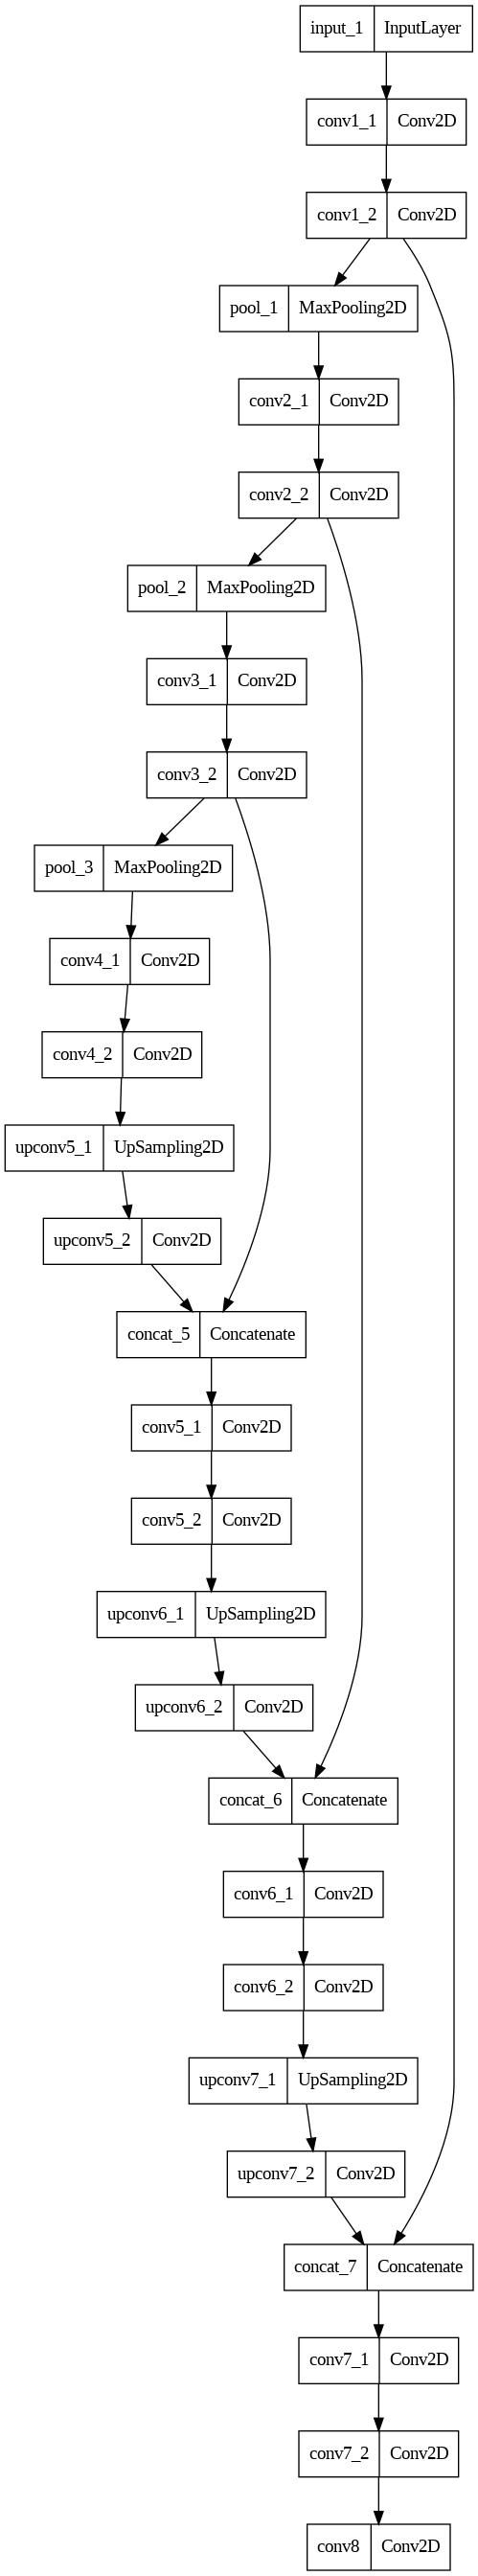

## 2.1. Создайте модель со следующей архитектурой:

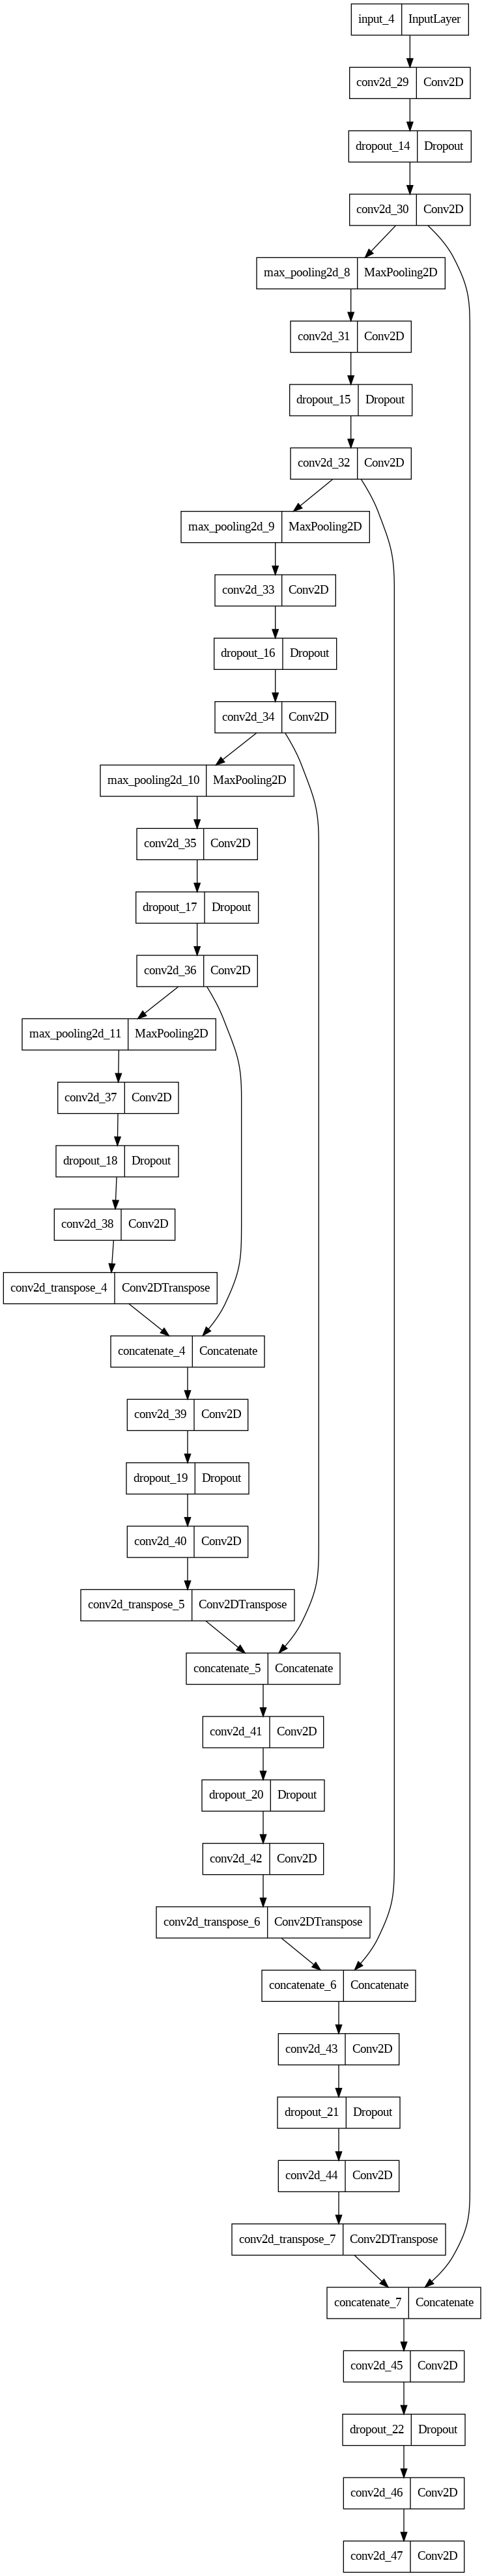

In [ ]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_14 (Dropout)           (None, 256, 256, 16  0           ['conv2d_29[0][0]']              
                                )                                                           

In [ ]:
model_2.get_config()

{'name': 'model_1',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_4'},
   'name': 'input_4',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_29',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d_29',
   'inbound_nodes': [[['input_4', 0, 0, {}]]]},
  {'class_name': 'Dropo

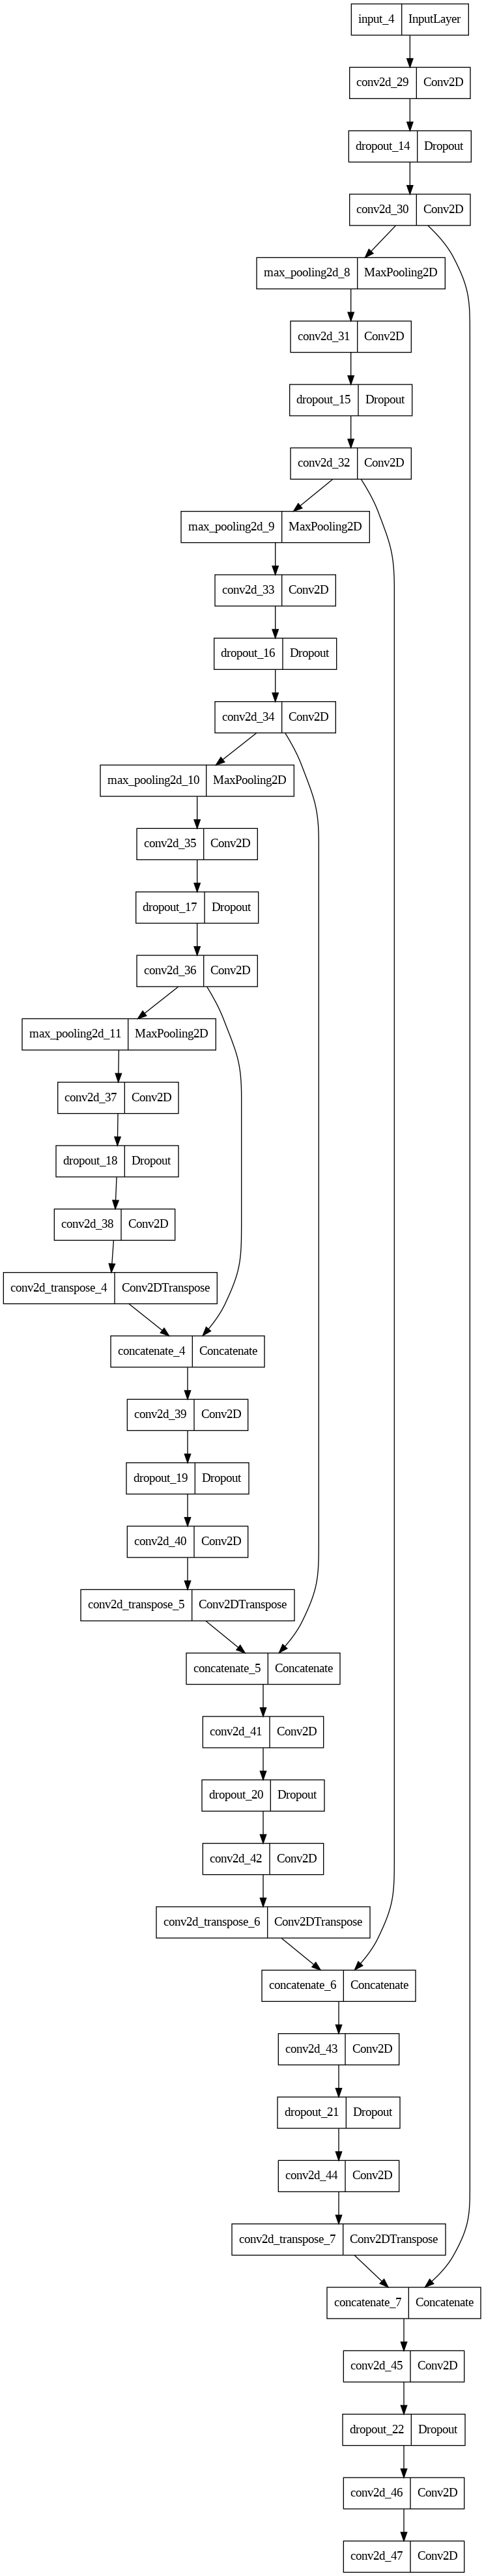

In [ ]:
plot_model(
model_2, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# Ваш код

## 2.2. Обучите созданную модель для решения задачи семантической сегментации. В качестве функции потерь используйте ту, которая лучше всего показала себя в задании №1

### 2.2.1. Загрузите три снимка, а также маски, соответствующие этим снимкам

In [ ]:
# Ваш код

### 2.2.2. Используя обученную модель, обработайте снимки по технологии, рассмотренной на практическом занятии (делим снимок на части, затем каждую часть обрабатываем нейросетью, а после соединяем все части для получения полноразмерной маски исходного снимка)

In [ ]:
# Ваш код

### 2.2.3. Загрузите наиболее удачную модель из предыдущего задания (Задания №1). Сравните её точность с моделью, обученной в этом задании:

In [ ]:
# Ваш код

### 2.2.4. Отобразите предсказанную маску для каждого из трех снимков, загруженных ранее, в следующем формате: (исходный снимок, эталонная маска, предсказанная маска по модели, обученной в этом задании, предсказанная маска по модели, обученной в первом задании.

In [ ]:
# Ваш код


# Задание №3. Реализация готового решения для полноразмерной семантической сегментации спутникового снимка

## Реализуйте готовый алгоритм, который принимает на вход полноразмерное изображение и маску (опционально). После чего на его основе формирует полноразмерную маску, предсказанную наиболее удачной моделью нейронной сети, обученной ранее в Задании №1 или Задании №2.

In [ ]:
# Ваш код

- Сравните получившийся результат с эталонной маской

In [ ]:
# Ваш код

- Реализуйте графический интерфейс с помощью Gradio. На вход подается только исходный растр - на выходе отображается сгенерированная маска. Также маска автоматически должна сохраняться в корневом каталоге.

In [ ]:
# Ваш код